---

<h1><center>RUL Prediction of Nasa Turbofan Engine - Group 45 <br><br> FD001 Dataset </center></h1>

---

# 0. Background on the Dataset
WRITE STUFF HERE

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng_seed = 2434 # Define seed for repeatability

# 1.1 Load Datasets and Append Target (RUL Series) to Datasets

In [2]:
# Column names from "Damage Propogation Modeling"
column_names = [
    'unit_number', 'time', 
    'altitude', 'machnum','tra',
    'T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30',
    'Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRc',
    'BPR', 'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32'
]

# Load .txt files
raw_train = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=column_names)
raw_test = pd.read_csv('test_FD001.txt', sep='\s+', header=None, names=column_names)
true_RUL = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
C:\Users\huanb\AppData\Local\Temp\ipykernel_11596\3091788156.py:11: SyntaxWarning: invalid escape sequence '\s'
  raw_train = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=column_names)
C:\Users\huanb\AppData\Local\Temp\ipykernel_11596\3091788156.py:12: SyntaxWarning: invalid escape sequence '\s'
  raw_test = pd.read_csv('test_FD001.txt', sep='\s+', header=None, names=column_names)
C:\Users\huanb\AppData\Local\Temp\ipykernel_11596\3091788156.py:13: SyntaxWarning: invalid escape sequence '\s'
  true_RUL = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])


# 1.2 Compute and Append Target (RUL Series) to Datasets
In general, $RUL=t_{fail}-t$. However, since each unit in the datasets begins in a healthy state with constant sensor readings, a purely linear model resulted in poor model prediction. Ideally, changepoint detection would be implemented to identify the constant and linear regime of RUL but this is out of scope. instead, the same piecewise RUL function is used where:
$$
RUL = \begin{cases} 
      RUL_{max} & t_{fail}-t > RUL_{max} \\
      t_{fail}-t & t_{fail}-t \leq RUL_{max}
   \end{cases} 
$$
A coarse value for `RUL_MAX` was found by inspecting the graphs of various sensors in the training data. `RUL_MAX=105` was found by manually search (changing RUL_MAX until an approximate stationary point in the training score was found).

In [3]:
# Define the variable for the RUL ceiling
RUL_MAX = 105

# Calculate RUL series (target) for each unit ID in training data using failure time 'T_fail'
RUL_series = np.array([])
unique_units = raw_train['unit_number'].unique()
for unit_ID in unique_units:
    unit_data = raw_train[raw_train['unit_number'] == unit_ID].copy()
    T_fail = unit_data['time'].max() # Since training set is run-to-failure
    
    RUL_linear = T_fail - unit_data['time']
    
    # Implementing Piecewise RUL
    RUL_series = np.concatenate((RUL_series, np.minimum(RUL_linear, RUL_MAX)),axis=0)
    
raw_train['RUL'] = RUL_series 

# Calculate RUL series for each Unit ID in test data using 'true_RUL'
RUL_series = np.array([])
for index, unit_ID in enumerate(unique_units):
    unit_data = raw_test[raw_test['unit_number'] == unit_ID].copy()
    
    T_last = unit_data['time'].max()
    RUL_last = true_RUL['RUL'][index]
    T_fail = T_last + RUL_last
    
    RUL_linear = T_fail - unit_data['time']
    
    # Implementing Piecewise RUL
    RUL_series = np.concatenate((RUL_series, np.minimum(RUL_linear, RUL_MAX)),axis=0)
    
raw_test['RUL'] = RUL_series

# 1.3 Prune Test Data
We are only concerned with predicting RUL for the last cycle of each unit in test data since `RUL_FD001.txt` only gives the true RUL for the last cycle. Thus, all rows before the last cycle are removed.

In [4]:
raw_test = raw_test.groupby('unit_number').last().reset_index()

# 1.4 Inspect and Clean Datasets
Inspect and remove columns from `raw_train` and `raw_test` if they contain Null or NaN values. No such columns were found

In [5]:
# Make copy of data sets
clean_train = raw_train.copy()
clean_test = raw_test.copy()

# Identify if columns have null values
is_null_arr = pd.isnull(clean_train)
col_has_null = np.any(is_null_arr ,axis=0)
drop_null_cols = clean_train.columns[col_has_null]
clean_train.drop(drop_null_cols, axis=1)
clean_test.drop(drop_null_cols, axis=1)
drop_null_cols

Index([], dtype='object')

In [6]:
# Identify if columns have NaN values
is_nan_arr = pd.isna(clean_train)
col_has_nan = np.any(is_nan_arr, axis=0)
drop_nan_cols = clean_train.columns[col_has_nan]
clean_train.drop(drop_nan_cols, axis=1)
clean_test.drop(drop_nan_cols, axis=1)
drop_nan_cols

Index([], dtype='object')

# 1.5 Feature Selection and Defining Input and Output Dataframes
Features are removed based on two rudimentary criteria:
1. Features that are constant across all units are removed because they hold no statistical power
2. If 2 features are highly correlated, they are redundant and one may be removed
+ **Additionally:**
1. The `'unit_number'` feature is merely to partition the time series of different instances of simulated turbofan engines **within the same dataset** which have randomly generated starting healths (efficiency and flow parameters) and degradation trajectorys (parameters of an exponential degradation model) sampled from the same distributions. `'unit_number'=1` in `train_FD001.txt` and `test_FD001.txt` are **different instances** and should not be conflated. Thus, `unit_number` is removed from the datasets to prevent the models from biasing the predictions due to arbitrarily matching unit IDs.
2. The columns representing the operational settings are **known** to be held constant for `FD001` so they are removed

In [7]:
drop_cols = ['unit_number', 'altitude', 'machnum', 'tra'] # Remove settings columns

# Check which sensors have constant values across all units
unique_count_series = clean_train.nunique()
unique_count_series[unique_count_series == 1]

tra          1
T2           1
P2           1
epr          1
farB         1
Nf_dmd       1
PCNfR_dmd    1
dtype: int64

In [8]:
drop_cols += ['T2', 'P2', 'P15', 'epr', 'farB', 'Nf_dmd', 'PCNfR_dmd'] # Remove useless sensors

# Identify feature pairs that have a abs(corr) higher than a threshhold
covariance_mat = clean_train.corr()
thresh = 0.95
highly_correlated_pairs = covariance_mat.stack().rename('Correlation')
highly_correlated_pairs = highly_correlated_pairs[abs(highly_correlated_pairs) >= thresh]
highly_correlated_pairs[highly_correlated_pairs != 1] # Remove pairs from diagonal entries

Nc   NRc    0.963157
NRc  Nc     0.963157
Name: Correlation, dtype: float64

In [9]:
drop_cols += ['NRc']

# Form feature and target matrices
Xtrain = clean_train.drop(drop_cols + ['RUL'], axis=1)
ytrain = clean_train['RUL']
Xtest = clean_test.drop(drop_cols + ['RUL'], axis=1)
ytest = clean_test['RUL']

# 2.1 Create Custom Scoring Function for GridSearchCV()
We will create a custom scorer for `GridSearchCV()` using the asymmetric scoring function presented in `"Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation"` which takes the form: 
$$ s = \begin{cases} 
      \sum_{i=1}^{n}e^{-\frac{d}{10}}-1 & d<0 \\
      \sum_{i=1}^{n}e^{\frac{d}{13}}-1 & d\geq0 
   \end{cases} 
   \quad \text{where } d = \hat{y}-y
$$
This scoring function is used because it penalizes late predictions ($d\geq0$) more heavily than early predictions ($d<0$). Since the goal is to avoid failure entirely, this scoring metric is most suitable for our dataset. It is also the same scoring function used to evaluate submissisons for the Prognostics and Health Management competition that this dataset was originallly created for. A score of $s=0$ means perfect prediction and a negative score is not possible.

In [10]:
from sklearn.metrics import make_scorer

# define scoring function
def asymmetric_score(y,yhat):
    d = yhat-y
    early_pred_score = np.sum(np.exp(-d[d<0]/10)-1)
    late_pred_score = np.sum(np.exp(d[d>=0]/13)-1)
    score = early_pred_score + late_pred_score
    return score

# Make scoring function accesible to GridSearchCV()
my_scorer = make_scorer(asymmetric_score,greater_is_better=False)

# 2.2 Hyper Parameter Tuning With Gridsearch
Will use `hypersolve()` from lab06 to tune hyperparameters. `plot_grid_results()` from `lab6_utils.py` was modified to plot negative MSE instead of accuracy. 
+ **NOTE:** `scoring='neg_mean_squared_error'` and `refit='neg_mean_squared_error'` arguments passed to `GridSearchCV()` for regression models,

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from lab6_utils import unpack_gridsearch, plot_grid_result

# Copied from Lab 06
def hypersolve(model,param_grid):
    # 1. Create the pipeline model
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    # 2. Construct the `GridSearchCV` object as was done in part 5.2
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring=my_scorer, # pass custom scoring function
        cv=3,
        refit=True
    )
    
    # 3. Run the grid search
    gs = gs.fit(Xtrain,ytrain)
    
    # 4. Run `unpack_gridsearch` to obtain the results dictionary.
    result = unpack_gridsearch(gs)

    # 5. Plot the result with `plot_grid_result`
    plot_grid_result(result)

    # 6. return result
    return result

# 3.1 Train Random Forest Regressor

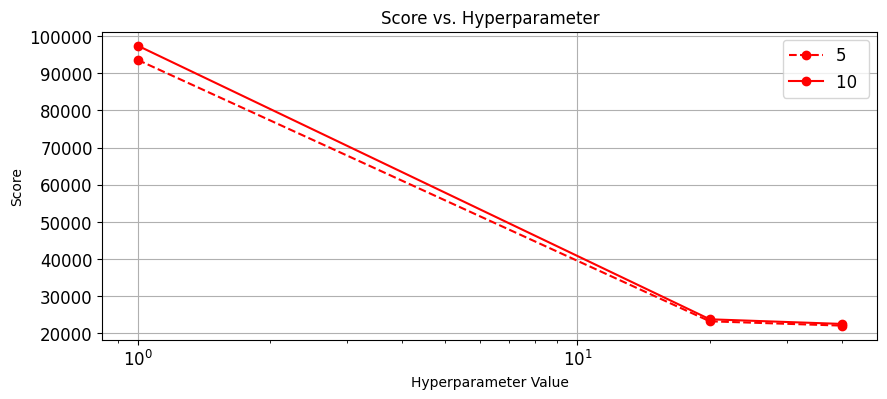

In [12]:
from sklearn.ensemble import RandomForestRegressor

# Define grid of viable hyper parameters
param_grid_rf = {
    'model__max_features' : [5, 10],#len(Xtrain.columns)],
    'model__n_estimators' : [1, 20, 40]
}

# Define an fit RF model
model = RandomForestRegressor(random_state=rng_seed)
result_rf = hypersolve(model, param_grid_rf)

In [13]:
result_rf

{'scoregrid': {5:     mean_test_score
  1      93582.929334
  20     23253.452802
  40     22089.694542,
  10:     mean_test_score
  1      97413.865278
  20     23792.753871
  40     22541.560555},
 'best_params': {'model__max_features': 5, 'model__n_estimators': 40},
 'best_estimator': Pipeline(steps=[('scaler', StandardScaler()),
                 ('model',
                  RandomForestRegressor(max_features=5, n_estimators=40,
                                        random_state=2434))]),
 'best_score': np.float64(22089.694542156194),
 'param_grid': {'model__max_features': [5, 10],
  'model__n_estimators': [1, 20, 40]}}

# 3.2 Store Best Random Forest Model and Training Score

In [14]:
best_rf_model = result_rf['best_estimator']
rf_train_score = result_rf['best_score']
rf_train_score

np.float64(22089.694542156194)

# 3.3 Predict Test RUL With Best Random Forest Regressor and Store Test Score
**NOTE:** test score will be higher than training score because `clean_test` was pruned to only include the last time cycle of each unit

In [15]:
yhat = best_rf_model.predict(Xtest)
rf_test_score = asymmetric_score(true_RUL['RUL'],yhat)
rf_test_score

np.float64(1158.5007471443496)

# 3.4 Plot Random Forest Prediction
Plot predicted and true RUL for all the last cycle of all units in test dataset

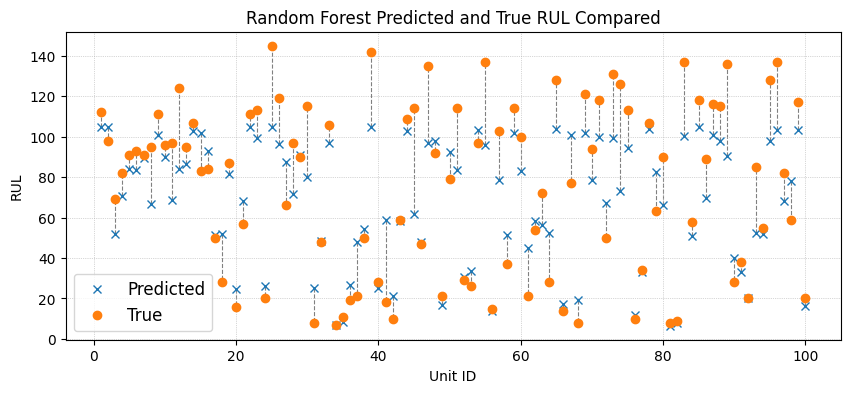

In [27]:
import numpy as np
import matplotlib.pyplot as plt


x = np.asarray(clean_test['unit_number'].to_numpy())
y_pred = np.asarray(yhat).ravel()
y_true = np.asarray(true_RUL).ravel()

assert len(x) == len(y_pred) == len(y_true)

plt.figure(figsize=(10,4))

#Plot predicted and true
plt.plot(x, y_pred, label='Predicted', marker='x', linestyle='None')
plt.plot(x, y_true, label='True', marker='o', linestyle='None')

#Connect each predicted point to the corresponding true value
for i in range(len(x)):
    plt.plot(
        [x[i], x[i]],
        [y_pred[i], y_true[i]],
        color='gray',
        linestyle='--',
        linewidth=0.8,
        zorder=0
    )
    
plt.title('Random Forest Predicted and True RUL Compared')
plt.xlabel('Unit ID')
plt.ylabel('RUL')
plt.legend(fontsize=12)
plt.grid(axis='both', linestyle=':', linewidth=0.5)
plt.show()

# 4.1 Train Simple Linear Regression


In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

feature_cols = [c for c in clean_train.columns 
                if c not in ['unit_number', 'RUL']]
X_train_lin = clean_train[feature_cols].values
y_train_lin = clean_train['RUL'].values
X_test_lin = clean_test[feature_cols].values
y_test_lin = clean_test['RUL'].values
linreg_model = Pipeline([
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])
linreg_model.fit(X_train_lin, y_train_lin)
yhat_linreg = linreg_model.predict(X_test_lin)
linreg_test_score = asymmetric_score(y_test_lin, yhat_linreg)
linreg_test_score

np.float64(623.3345034458932)

# 4.2 Plot Linear Regression


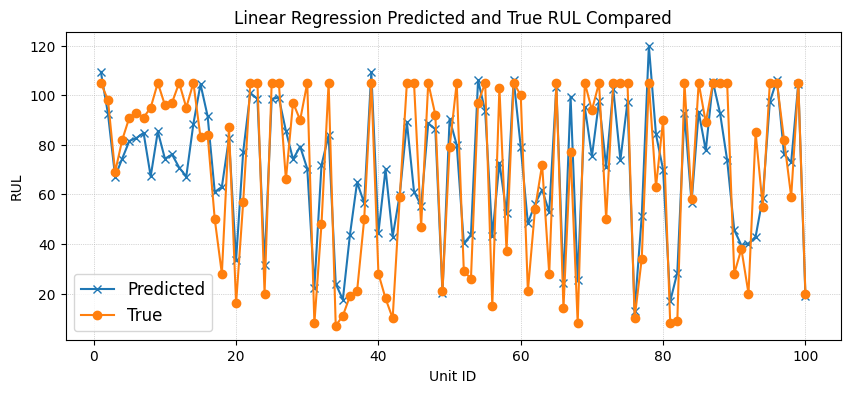

In [18]:
plt.figure(figsize=(10, 4))
plt.plot(clean_test['unit_number'], yhat_linreg, label='Predicted', marker='x')
plt.plot(clean_test['unit_number'], y_test_lin, label='True', marker='o')
plt.title("Linear Regression Predicted and True RUL Compared")
plt.xlabel("Unit ID")
plt.ylabel("RUL")
plt.legend(fontsize=12)
plt.grid(axis='both', linestyle=':', linewidth=0.5)
plt.show()

# 4.3 Store Linear Regression Model and Score


In [19]:
best_linreg_model = linreg_model
best_linreg_score = linreg_test_score
best_linreg_score

np.float64(623.3345034458932)

# 5.1 Plot Linear Regression


In [20]:
#%pip install --upgrade pip
#%pip install "numpy<1.24"
#%pip install --upgrade tensorflow==2.19.0

In [21]:
import numpy as np
from sklearn.preprocessing import StandardScaler

feature_cols_mlp = [c for c in clean_train.columns 
                    if c not in ['unit_number', 'RUL']]
X_train_mlp = clean_train[feature_cols_mlp].values
y_train_mlp = clean_train['RUL'].values
X_test_mlp = clean_test[feature_cols_mlp].values
y_test_mlp = clean_test['RUL'].values
scaler_mlp = StandardScaler()
X_train_mlp_scaled = scaler_mlp.fit_transform(X_train_mlp)
X_test_mlp_scaled = scaler_mlp.transform(X_test_mlp)

# 5.2 Build and Train MLP Model for RUL Prediction


In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import GlorotUniform

random_seed = 2434
tf.random.set_seed(random_seed)
np.random.seed(random_seed)
ki = GlorotUniform(seed=random_seed)
D_mlp = X_train_mlp_scaled.shape[1]
model_mlp = Sequential([
    Dense(64, activation='relu', kernel_initializer=ki, input_shape=(D_mlp,)),
    Dense(32, activation='relu', kernel_initializer=ki),
    Dense(16, activation='relu', kernel_initializer=ki),
    Dense(1, activation='linear', kernel_initializer=ki),
])
model_mlp.compile(
    optimizer="rmsprop",
    loss="mse",
    metrics=["mae"]
)
history_mlp = model_mlp.fit(
    X_train_mlp_scaled,
    y_train_mlp,
    epochs=20,
    batch_size=256,
    validation_split=0.2,
    verbose=0
)
yhat_mlp_test = model_mlp.predict(X_test_mlp_scaled)
yhat_mlp_test = yhat_mlp_test.reshape(-1)
mlp_test_score = asymmetric_score(y_test_mlp, yhat_mlp_test)
mlp_test_score

ModuleNotFoundError: No module named 'tensorflow'

# 5.3 Plot MLP


In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(clean_test['unit_number'], yhat_mlp_test, 
         label='Predicted', marker='x')
plt.plot(clean_test['unit_number'], y_test_mlp, 
         label='True', marker='o')
plt.title("MLP Predicted and True RUL Compared")
plt.xlabel("Unit ID")
plt.ylabel("RUL")
plt.legend(fontsize=12)
plt.grid(axis='both', linestyle=':', linewidth=0.5)
plt.show()

NameError: name 'yhat_mlp_test' is not defined

<Figure size 1000x400 with 0 Axes>

# 5.3 Store MLP Model and Score


In [ ]:
best_mlp_model = model_mlp
best_mlp_score = mlp_test_score
best_mlp_score

NameError: name 'model_mlp' is not defined

# 6.1 Build and Train Adaboost Model for RUL Prediction

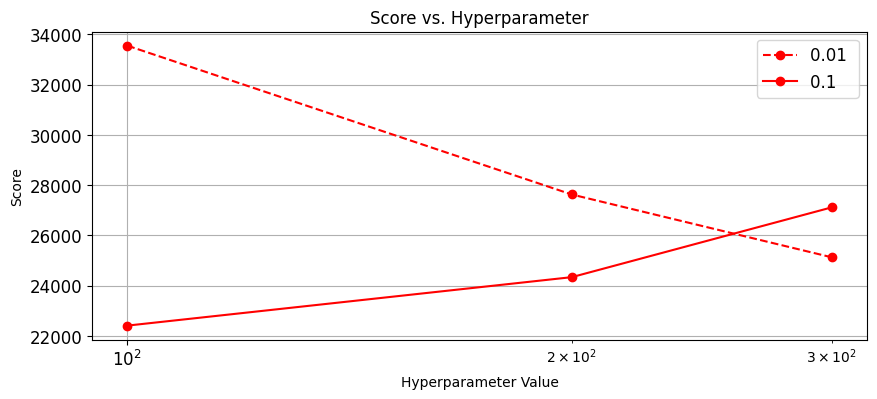

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

base = DecisionTreeRegressor(max_depth=3)

model_ab = AdaBoostRegressor(
    estimator=base,
    n_estimators=200,
    learning_rate=0.1,
    random_state=rng_seed
)

param_grid_ab = {
    'model__learning_rate': [0.01, 0.1],    
    'model__n_estimators': [100, 200, 300]  
}

result_ab = hypersolve(model_ab, param_grid_ab)

# 6.2 Store Best Adaboost Model and Training Score

In [ ]:
best_ab_model = result_ab['best_estimator']
ab_train_score = result_ab['best_score']
ab_train_score

np.float64(22411.182297821764)

# 6.3 Predict Best Adaboost Model Score 


In [ ]:
yhat = best_ab_model.predict(Xtest)
ab_test_score = asymmetric_score(true_RUL['RUL'],yhat)
ab_test_score

np.float64(1717.0926069895731)

# 6.4 Plot Adaboost Predictions and True RUL Comparison

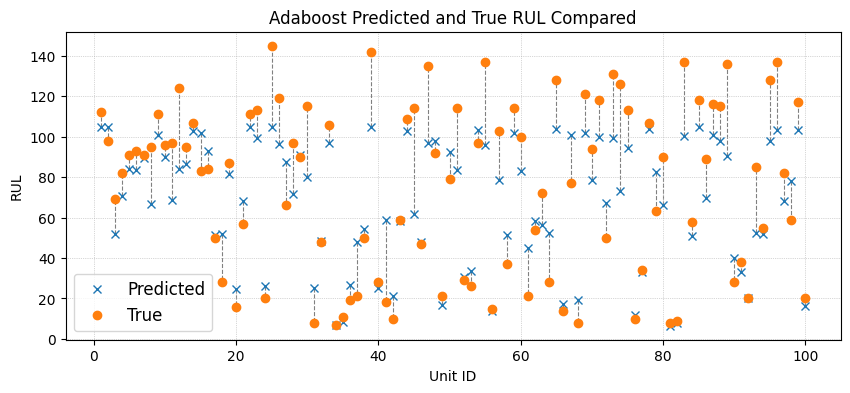

In [24]:
import numpy as np
import matplotlib.pyplot as plt


x = np.asarray(clean_test['unit_number'].to_numpy())
y_pred = np.asarray(yhat).ravel()
y_true = np.asarray(true_RUL).ravel()

assert len(x) == len(y_pred) == len(y_true)

plt.figure(figsize=(10,4))

#Plot predicted and true
plt.plot(x, y_pred, label='Predicted', marker='x', linestyle='None')
plt.plot(x, y_true, label='True', marker='o', linestyle='None')

#Connect each predicted point to the corresponding true value
for i in range(len(x)):
    plt.plot(
        [x[i], x[i]],
        [y_pred[i], y_true[i]],
        color='gray',
        linestyle='--',
        linewidth=0.8,
        zorder=0
    )

    
plt.title('Adaboost Predicted and True RUL Compared')
plt.xlabel('Unit ID')
plt.ylabel('RUL')
plt.legend(fontsize=12)
plt.grid(axis='both', linestyle=':', linewidth=0.5)
plt.show()

# 7.1 Build and Train Gradient Boosting Trees for RUL Prediction

In [ ]:

from sklearn.ensemble import GradientBoostingRegressor
model_gb = GradientBoostingRegressor(random_state=rng_seed)

param_grid_gb = {
    'model__learning_rate': [0.01, 0.05],    
    'model__n_estimators': [100, 200, 300]  
}

result_gb = hypersolve(model_gb, param_grid_gb)

# 7.2 Store Best Gradient Boosting Trees Model and Training Score

In [ ]:
best_gb_model = result_gb['best_estimator']
gb_train_score = result_gb['best_score']
gb_train_score

np.float64(20677.89518911306)

# 7.3 Predict Best Gradient Boosting Trees Model Score 

In [ ]:
yhat = best_gb_model.predict(Xtest)
gb_test_score = asymmetric_score(true_RUL['RUL'],yhat)
gb_test_score

np.float64(1074.9237217920668)

# 7.4 Plot Best Gradient Boosting Trees Predictions and True RUL Comparison

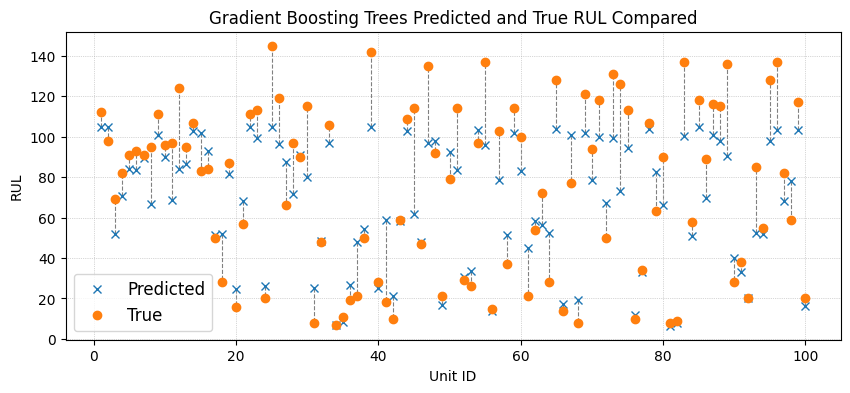

In [23]:
import numpy as np
import matplotlib.pyplot as plt


x = np.asarray(clean_test['unit_number'].to_numpy())
y_pred = np.asarray(yhat).ravel()
y_true = np.asarray(true_RUL).ravel()

assert len(x) == len(y_pred) == len(y_true)

plt.figure(figsize=(10,4))

#Plot predicted and true
plt.plot(x, y_pred, label='Predicted', marker='x', linestyle='None')
plt.plot(x, y_true, label='True', marker='o', linestyle='None')

#Connect each predicted point to the corresponding true value
for i in range(len(x)):
    plt.plot(
        [x[i], x[i]],
        [y_pred[i], y_true[i]],
        color='gray',
        linestyle='--',
        linewidth=0.8,
        zorder=0
    )

plt.title('Gradient Boosting Trees Predicted and True RUL Compared')
plt.xlabel('Unit ID')
plt.ylabel('RUL')
plt.legend(fontsize=12)
plt.grid(axis='both', linestyle=':', linewidth=0.5)
plt.show()